<a href="https://colab.research.google.com/github/AP-047/RClass-Classification-by-Rational-Approximation/blob/main/notebooks/02_model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Model Training

Step 1: Load a Small Subset of Data (100 Images)

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist

# Load the MNIST dataset
(train_X, train_y), (_, _) = mnist.load_data()

# Select 10 samples per digit (0–9) for a total of 100 samples
selected_indices = []
for digit in range(1000):
    indices = np.where(train_y == digit)[0][:1000]
    selected_indices.extend(indices)

# Create the subset
train_X_small = train_X[selected_indices]
train_y_small = train_y[selected_indices]

# Confirm the shape
print("Shape of the subset images:", train_X_small.shape)
print("Labels in the subset:", train_y_small)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Shape of the subset images: (10000, 28, 28)
Labels in the subset: [0 0 0 ... 9 9 9]


Step 2: Convert Images to Black and White

First binary image representation (0=black, 1=white):


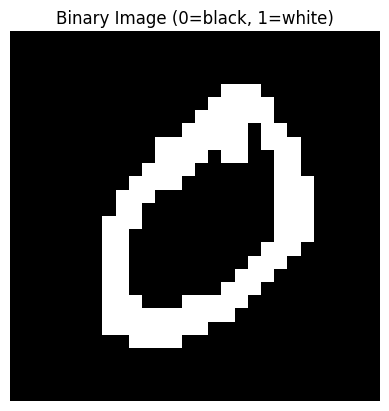

In [2]:
import matplotlib.pyplot as plt

# Convert images to black and white using a threshold of 128
train_X_bw = (train_X_small > 128).astype(int)

# Confirm the conversion by printing the first binary image as an example
print("First binary image representation (0=black, 1=white):")

plt.imshow(train_X_bw[0], cmap='gray')
plt.title("Binary Image (0=black, 1=white)")
plt.axis('off')  # Hide the axis for a cleaner look
plt.show()

Step 3: Calculate Final Unique Value Using Row-Wise and Column-Wise Approaches Combined

In [3]:
# Function to calculate combined row-wise and column-wise indices-based sum for an image
def calculate_combined_indices_sum(image):
    # Row-wise calculation
    row_sum = 0
    for row_index, row in enumerate(image):
        for col_index, pixel in enumerate(row):
            if pixel == 1:  # Only consider active pixels
                coefficient_row = (row_index + 1) * 10 + (col_index + 1)
                row_sum += coefficient_row

    # Column-wise calculation
    col_sum = 0
    for col_index in range(image.shape[1]):
        for row_index, pixel in enumerate(image[:, col_index]):
            if pixel == 1:  # Only consider active pixels
                coefficient_col = (row_index + 1) * 10 + (col_index + 1)
                col_sum += coefficient_col

    # Combined final value
    final_value = row_sum + col_sum
    return final_value

# Calculate the combined indices-based sum for each image in the subset
final_combined_sums = [calculate_combined_indices_sum(img) for img in train_X_bw]

# Print the combined indices-based sum for each digit in the subset
for digit, combined_sum in zip(train_y_small, final_combined_sums):
    print(f"Digit {digit}: Combined Indices-Based Sum = {combined_sum}")

Streaming output truncated to the last 5000 lines.
Digit 5: Combined Indices-Based Sum = 37120
Digit 5: Combined Indices-Based Sum = 18562
Digit 5: Combined Indices-Based Sum = 21380
Digit 5: Combined Indices-Based Sum = 26238
Digit 5: Combined Indices-Based Sum = 22400
Digit 5: Combined Indices-Based Sum = 22906
Digit 5: Combined Indices-Based Sum = 22898
Digit 5: Combined Indices-Based Sum = 37260
Digit 5: Combined Indices-Based Sum = 24178
Digit 5: Combined Indices-Based Sum = 19476
Digit 5: Combined Indices-Based Sum = 30462
Digit 5: Combined Indices-Based Sum = 35156
Digit 5: Combined Indices-Based Sum = 21092
Digit 5: Combined Indices-Based Sum = 32804
Digit 5: Combined Indices-Based Sum = 39136
Digit 5: Combined Indices-Based Sum = 33222
Digit 5: Combined Indices-Based Sum = 50856
Digit 5: Combined Indices-Based Sum = 31560
Digit 5: Combined Indices-Based Sum = 36736
Digit 5: Combined Indices-Based Sum = 30916
Digit 5: Combined Indices-Based Sum = 31594
Digit 5: Combined Indices

Step 4: Define the Rational Function

In [4]:
import numpy as np

# Define the rational function model
def rational_function(x, a, b, c, d):
    # Rational function of form: (a * x**2 + b * x + c) / (d * x + 1)
    return (a * x**2 + b * x + c) / (d * x + 1)

# Initialize parameters a, b, c, and d
# These values will be optimized during training
a, b, c, d = np.random.randn(4)

print("Initial parameters:", a, b, c, d)

Initial parameters: 0.13131720720838821 -0.7587840013153276 -1.6022258960744034 -0.05006078543413479


In [5]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Nov  2 13:25:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Test

In [6]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

import torch
print("CUDA Available: ", torch.cuda.is_available())

Num GPUs Available:  1
CUDA Available:  True


Step 5: Define the Loss Function and Perform Optimization

In [7]:
# Define X and y from the previously computed final combined sums and labels
X = np.array(final_combined_sums).reshape(-1, 1)  # Single feature input
y = np.array(train_y_small)  # Corresponding labels for each digit

# Now scale down X
X_scaled = X / 1000  # Adjust the scaling factor as needed

# Initialize parameters (assuming a, b, c, d are already defined)
num_epochs = 1000
learning_rate = 0.001
loss_values = []

# Training loop
for epoch in range(num_epochs):
    # Predictions for all scaled training inputs
    y_pred = rational_function(X_scaled, a, b, c, d)

    # Calculate loss
    loss = np.mean((y_pred - y) ** 2)
    loss_values.append(loss)

    # Calculate gradients (replacing X with X_scaled in gradient calculations)
    grad_a = np.mean(2 * (y_pred - y) * (X_scaled**2) / (d * X_scaled + 1))
    grad_b = np.mean(2 * (y_pred - y) * X_scaled / (d * X_scaled + 1))
    grad_c = np.mean(2 * (y_pred - y) / (d * X_scaled + 1))
    grad_d = np.mean(-2 * (y_pred - y) * (a * X_scaled**2 + b * X_scaled + c) * X_scaled / ((d * X_scaled + 1) ** 2))

    # Update parameters
    a -= learning_rate * grad_a
    b -= learning_rate * grad_b
    c -= learning_rate * grad_c
    d -= learning_rate * grad_d

    # Print loss every 100 epochs for monitoring
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss:.4f}")

# Plot the loss to observe convergence
import matplotlib.pyplot as plt

plt.plot(loss_values)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.show()


Epoch 0, Loss: 3602492.4526


KeyboardInterrupt: 